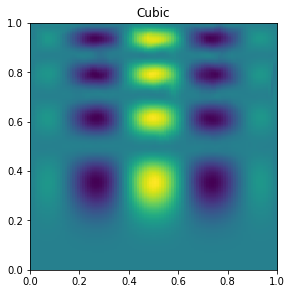

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata


def func(x, y):
    """Target function"""
    return x*(1-x)*np.cos(4*np.pi*x) * np.sin(4*np.pi*y**2)**2



def func1(x, y):
    """Target function"""
    return x*(1-x)*y




def get_samples(N):
    X = np.random.rand(N, 2)  # N x 2
    y = func(X[:, 0], X[:, 1])  # N x 1
    return X, y



# randomly sample N Points
N = 1000
# Train data set
X_train_np, y_train_np = get_samples(N)

X_train, y_train = torch.from_numpy(X_train_np).float(), torch.from_numpy(y_train_np).float().reshape(-1, 1)




# Evaluate the 2d-spline interpolation on a regular grid
grid_x1, grid_x2 = np.mgrid[0:1:100j, 0:1:200j]

grid_z2 = griddata(points=X_train_np, values=y_train_np, xi=(grid_x1, grid_x2), method='cubic', fill_value=0)



plt.subplot(224)
plt.imshow(grid_z2.T, extent=(0,1,0,1), origin='lower')
plt.title('Cubic')
gcf = plt.gcf()
gcf.set_size_inches(10, 10)
plt.show()

In [98]:
# Quelle: https://github.com/MorvanZhou/PyTorch-Tutorial/blob/master/tutorial-contents/301_regression.py
# angepasst auf 2d-Fall


import torch
import torch.nn.functional as F


class Net(torch.nn.Module):
    
    def __init__(self, n_feature, hl_sizes, n_output):
        super(Net, self).__init__()
        self.activation_func = torch.relu
        self.hidden_layers = []
        n_in = n_feature
        n_out = None
        for s in hl_sizes:
            self.hidden_layers.append(torch.nn.Linear(n_in, s))
            n_in = s
        
        self.predict = torch.nn.Linear(n_in, n_output)   # output layer

    def forward(self, x):
        for hl in self.hidden_layers:
            x = self.activation_func(hl(x))
        x = self.predict(x)             # linear output
        return x



In [99]:
net = Net(n_feature=2, hl_sizes=[128, 62, 32, 16], n_output=1)     # define the network
print(net)  # net architecture

optimizer = torch.optim.SGD(net.parameters(), lr=0.1)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss


Net(
  (predict): Linear(in_features=16, out_features=1, bias=True)
)


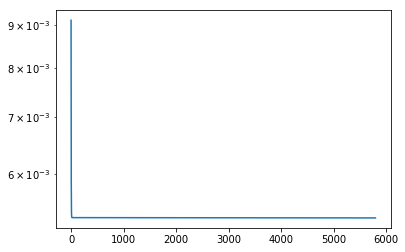

In [100]:

# plt.ion()   # something about plotting
loss_over_epoch = []
for t in range(5800):
    prediction = net(X_train)     # input x and predict based on x

    loss = loss_func(prediction, y_train)     # must be (1. nn output, 2. target)
    loss_over_epoch.append(loss.data.numpy())

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients


plt.figure()
plt.semilogy(loss_over_epoch)
# plt.ioff()
plt.show()

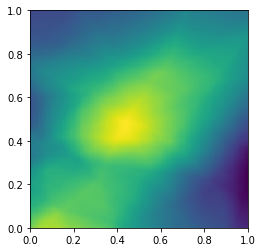

In [101]:
import itertools as it
xx_grid = torch.from_numpy( np.array(list(it.product(grid_x1[:,0], grid_x2.T[:,0]))) ).float()

grid_prediction = net(xx_grid).reshape(*grid_x1.shape)

grid_prediction.shape

plt.imshow(grid_prediction.data.numpy().T, extent=(0,1,0,1), origin='lower')